# MIDS DATASCI 205 Project 3 Graph Data Tests

## Imports

In [64]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings

import neo4j
import math
from IPython.display import display
import psycopg2

## Data Loading

In [19]:
# Loading in correlation data
corr_df = pd.read_csv("SP500_Corr_PDC_Pct_Chg.csv", index_col='Unnamed: 0')

# Creating a new correlation df with a threshold of 0.3
corr_df_thresh = corr_df[corr_df['Correlation'] >= 0.3]

corr_df_thresh

,Ticker_1,Ticker_2,Correlation
3,A,AAPL,0.481627
5,A,ABT,0.547876
6,A,ACN,0.559315
7,A,ADBE,0.502190
8,A,ADI,0.547926
...,...,...,...
225617,ZTS,XRAY,0.373792
225619,ZTS,XYL,0.438852
225620,ZTS,YUM,0.436787
225621,ZTS,ZBH,0.360940


## Postgres pandas queries

In [20]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [21]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [22]:
cursor = connection.cursor()

## Neo4j

In [23]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [24]:
session = driver.session(database="neo4j")

In [25]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [26]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [71]:
def my_neo4j_nodes_relationships():
    "print all the nodes and relationships"
   
    print("-------------------------")
    print("  Nodes:")
    print("-------------------------")
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    display(df)
    
    print("-------------------------")
    print("  Relationships:")
    print("-------------------------")
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    query = """        
        MATCH (a:Ticker)-[r:CORRELATED_WITH]->(b:Ticker)
        RETURN a.name AS Ticker1, b.name AS Ticker2, r.correlation AS Correlation, r.distance AS Distance
        ORDER BY Correlation DESC
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    display(df)
    
    density = (2 * number_relationships) / (number_nodes * (number_nodes - 1))
    
    print("-------------------------")
    print("  Density:", f'{density:.1f}')
    print("-------------------------")
    

## Creating the initial correlation graph

In [72]:
def create_correlation_graph(df):
    
    my_neo4j_wipe_out_database()
    
    for index, row in df.iterrows():
        ticker1 = row["Ticker_1"]
        ticker2 = row["Ticker_2"]
        correlation = row["Correlation"]
        
        # Converting correlation to a "distance" where higher correlation equates to shorter distance
        # (This avoids division by zero and keeps values positive)
        distance = round(1 - correlation, 5)  

        # Creating nodes (if not exist)
        session.run("""
            MERGE (t1:Ticker {name: $ticker1})
            MERGE (t2:Ticker {name: $ticker2})
            MERGE (t1)-[r:CORRELATED_WITH]->(t2)
            SET r.correlation = $correlation, r.distance = $distance
        """, ticker1=ticker1, ticker2=ticker2, correlation=correlation, distance=distance)

In [73]:
create_correlation_graph(corr_df_thresh[:1000])

In [74]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,A,[Ticker]
1,AAL,[Ticker]
2,AAP,[Ticker]
3,AAPL,[Ticker]
4,ABT,[Ticker]
...,...,...
374,YUM,[Ticker]
375,ZBH,[Ticker]
376,ZBRA,[Ticker]
377,ZION,[Ticker]


-------------------------
  Relationships:
-------------------------


,Ticker1,Ticker2,Correlation,Distance
0,AAL,UAL,0.892103,0.10790
1,AAL,DAL,0.879372,0.12063
2,A,MTD,0.807370,0.19263
3,A,WAT,0.805616,0.19438
4,AAL,ALK,0.777443,0.22256
...,...,...,...,...
995,A,SO,0.300882,0.69912
996,A,CMA,0.300744,0.69926
997,AAL,CB,0.300716,0.69928
998,AAP,EBAY,0.300631,0.69937


-------------------------
  Density: 0.0
-------------------------


## Creating the correlation graph with a random 100 tickers

In [58]:
np.random.seed(0)

# Getting a random 100 tickers to build a graph with
unique_tickers = corr_df_thresh['Ticker_1'].unique()
indices = np.arange(len(unique_tickers))
shuffled_indices = np.random.permutation(indices)
tickers_100 = unique_tickers[shuffled_indices[:100]]

# Getting a correlation dataframe with only the 100 random tickers
corr_df_100 = corr_df_thresh[(corr_df_thresh['Ticker_1'].isin(tickers_100)) &
                             (corr_df_thresh['Ticker_2'].isin(tickers_100))]

In [61]:
# Checking to see how many tickers ended up in both Ticker_1 and Ticker_2
print("Number of tickers in Ticker_1:", corr_df_100.Ticker_1.nunique())
print("Number of tickers in Ticker_2:", corr_df_100.Ticker_2.nunique())

Number of tickers in Ticker_1: 99
Number of tickers in Ticker_2: 99


This means that one of the tickers in the random 100 had no correlation above 0.3 with any of the other tickers. This just means that one ticker will be removed, which is fine for our testing.

In [75]:
create_correlation_graph(corr_df_100)

In [76]:
my_neo4j_nodes_relationships()

-------------------------
  Nodes:
-------------------------


,node_name,labels
0,AAL,[Ticker]
1,ACN,[Ticker]
2,ADBE,[Ticker]
3,ADI,[Ticker]
4,ADP,[Ticker]
...,...,...
94,WY,[Ticker]
95,XEL,[Ticker]
96,XRX,[Ticker]
97,YUM,[Ticker]


-------------------------
  Relationships:
-------------------------


,Ticker1,Ticker2,Correlation,Distance
0,PRU,MET,0.894975,0.10503
1,MET,PRU,0.894975,0.10503
2,REG,KIM,0.872812,0.12719
3,KIM,REG,0.872812,0.12719
4,CSX,NSC,0.855464,0.14454
...,...,...,...,...
6001,BKR,BKNG,0.300229,0.69977
6002,PSA,JBHT,0.300124,0.69988
6003,JBHT,PSA,0.300124,0.69988
6004,ED,SEE,0.300116,0.69988


-------------------------
  Density: 1.2
-------------------------


## Clustering Coefficient

In [79]:
query = "CALL gds.graph.drop('ds_graph', false) YIELD graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Ticker', {CORRELATED_WITH: {orientation: 'UNDIRECTED'}})"
session.run(query)

In [80]:
query = """

CALL gds.localClusteringCoefficient.stream('ds_graph')
YIELD nodeId, localClusteringCoefficient
RETURN gds.util.asNode(nodeId).name AS name, localClusteringCoefficient as clustering_coefficient
ORDER BY localClusteringCoefficient DESC, name

"""

my_neo4j_run_query_pandas(query)


,name,clustering_coefficient
0,DVA,1.000000
1,TTWO,0.986928
2,BKR,0.985755
3,CVX,0.977833
4,LW,0.972973
...,...,...
94,AFL,0.705260
95,KIM,0.703762
96,REG,0.689888
97,ITW,0.683272


## Louvain Modularity

In [87]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = """

CALL gds.graph.project('ds_graph', 'Ticker', 'CORRELATED_WITH', 
                      {relationshipProperties: 'distance'})
"""

session.run(query)

In [98]:
query = """

CALL gds.louvain.stream('ds_graph', {includeIntermediateCommunities: true})
YIELD nodeId, communityId, intermediateCommunityIds
RETURN gds.util.asNode(nodeId).name AS name, communityId as community, intermediateCommunityIds as intermediate_community
ORDER BY community, name ASC

"""

lm_df = my_neo4j_run_query_pandas(query)

lm_df

,name,community,intermediate_community
0,ACN,52,[52]
1,ADBE,52,[52]
2,ADI,52,[52]
3,ALGN,52,[52]
4,BBY,52,[52]
...,...,...,...
94,TPR,70,[70]
95,UNM,70,[70]
96,WBD,70,[70]
97,WY,70,[70]


In [99]:
# Checking the communities in the louvain modularity dataframe
lm_df['community'].unique()  # Only 3 communities

array([52, 67, 70])

In [100]:
# Getting S&P500 current list of stocks and their sectors/sub-industries
sp500_tables = pd.read_csv('SP500_Tickers_March_2025.csv', index_col='Unnamed: 0')

# Getting the sector and sub-industries for stocks as another feature
ticker_and_sector = sp500_tables[['Symbol', 'GICS Sector', 'GICS Sub-Industry']]

# Adding the sector and sub-industry for each stock
lm_df = lm_df.reset_index().merge(ticker_and_sector, left_on='name', right_on='Symbol', how='left')
lm_df = lm_df.drop(columns=['Symbol'])

# Replacing NaN GICS Sectors and Sub-Industries with Other
lm_df['GICS Sector'] = lm_df['GICS Sector'].fillna('Other')
lm_df['GICS Sub-Industry'] = lm_df['GICS Sub-Industry'].fillna('Other')

In [158]:
# Getting the grouping df after finding louvain modularity communities
lm_sector_grouping = lm_df.groupby('community')['GICS Sector'].value_counts()
lm_sector_grouping = lm_sector_grouping.reset_index(name='Count')

lm_sector_pivot = lm_sector_grouping.pivot(index='GICS Sector', columns='community', values='Count').fillna(0)

lm_sector_pivot

community,52,67,70
GICS Sector,,,
Communication Services,5.0,1.0,2.0
Consumer Discretionary,7.0,0.0,5.0
Consumer Staples,0.0,3.0,2.0
Energy,0.0,0.0,6.0
Financials,3.0,2.0,7.0
Health Care,7.0,2.0,0.0
Industrials,6.0,5.0,3.0
Information Technology,7.0,0.0,2.0
Materials,0.0,1.0,1.0


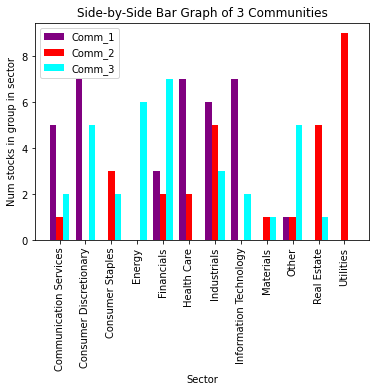

In [153]:
# Setting conditions for bar graph
x = np.arange(len(lm_sector_pivot))  # Positions for categories
width = 0.25
columns = lm_sector_pivot.columns

# Plotting a bar graph of the sectors
plt.bar(x - width, lm_sector_pivot[52], width, label="Comm_1", color="purple")
plt.bar(x, lm_sector_pivot[67], width, label="Comm_2", color="red")
plt.bar(x + width, lm_sector_pivot[70], width, label="Comm_3", color="cyan")
plt.xticks(x, lm_sector_pivot.index, rotation=90)
plt.xlabel("Sector")
plt.ylabel("Num stocks in group in sector")
plt.title("Side-by-Side Bar Graph of 3 Communities")
plt.legend(loc='upper left')
plt.show()

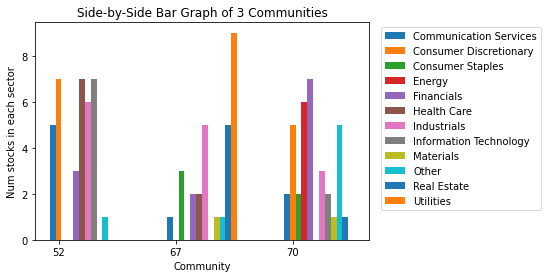

In [171]:
# Trying the bar graph again, but with the sectors as the labels and the communites on the x-axis
lm_sector_pivot_2 = lm_sector_grouping.pivot(index='community', columns='GICS Sector', values='Count').fillna(0)

# Setting conditions for bar graph
x_2 = np.arange(len(lm_sector_pivot.columns))  # One x-position per column group
width_2 = 0.05
columns_2 = lm_sector_pivot.columns

# Plotting each row (community) as its own set of bars
for i, community in enumerate(lm_sector_pivot.index):
    plt.bar(x_2 + (i - 1)*width_2, lm_sector_pivot.loc[community], width_2, label=community)
plt.xticks(x_2, lm_sector_pivot_2.index)
plt.xlabel("Community")
plt.ylabel("Num stocks in each sector")
plt.title("Side-by-Side Bar Graph of 3 Communities")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

It seems that for the test above, Community 52 has many stocks in the Consumer Discretionary, Health Care, and IT sectors; Community 67 has stocks primarily in Utilies, with some in Industrials and Real Estate; and Community 70 primarily has stocks in Energy and Financials. While there is some overlap (Community 52 also has a lot of Industrials stocks as well, and Community 70 also has quite a few Consumer Discretionary stocks), the different sectors have in general been separated pretty well. Perhaps with more buckets (i.e., greater than 3), the Louvain Modularity community detection could have separated the communities even more precisely.

## Degree Centrality

In [178]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Ticker', 'CORRELATED_WITH', {relationshipProperties: 'distance'})"
session.run(query)

In [180]:
query = """

CALL gds.degree.stream('ds_graph')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as degree
ORDER BY degree DESC, name

"""

my_neo4j_run_query_pandas(query)

,name,degree
0,ITW,91.0
1,REG,90.0
2,BEN,88.0
3,KIM,88.0
4,CPAY,86.0
...,...,...
94,TTWO,18.0
95,PGR,16.0
96,K,11.0
97,DVA,2.0


## Closeness Centrality - Harmonic Centrality

In [181]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Ticker', 'CORRELATED_WITH', {relationshipProperties: 'distance'})"
session.run(query)

In [182]:
query = """

CALL gds.closeness.harmonic.stream('ds_graph', {})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as closeness
ORDER BY closeness DESC

"""

my_neo4j_run_query_pandas(query)


,name,closeness
0,ITW,0.964286
1,REG,0.959184
2,KIM,0.948980
3,BEN,0.948980
4,IVZ,0.938776
...,...,...
94,TTWO,0.585034
95,PGR,0.574830
96,K,0.525510
97,DVA,0.476190


## Betweenness Centrality - all pairs shortest path

In [183]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Ticker', {CORRELATED_WITH: {properties: 'distance'}})"
session.run(query)

In [184]:
query = """

CALL gds.betweenness.stream('ds_graph', {relationshipWeightProperty: 'distance'})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as betweenness
ORDER BY betweenness DESC

"""

my_neo4j_run_query_pandas(query)


,name,betweenness
0,PRU,588.0
1,ITW,384.0
2,IVZ,238.0
3,KIM,234.0
4,TMO,200.0
...,...,...
94,DVA,0.0
95,REGN,0.0
96,ALGN,0.0
97,BBY,0.0


It appears a lot of stocks go through PRU as the shortest path, potentially because PRU happens to be connected with a lot of stocks.

## Page Rank

In [185]:
query = "CALL gds.graph.drop('ds_graph', false) yield graphName"
session.run(query)

query = "CALL gds.graph.project('ds_graph', 'Ticker', 'CORRELATED_WITH', {relationshipProperties: 'distance'})"
session.run(query)

In [186]:
query = """

CALL gds.pageRank.stream('ds_graph',
                         { maxIterations: $max_iterations,
                           dampingFactor: $damping_factor}
                         )
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score as page_rank
ORDER BY page_rank DESC, name ASC

"""

max_iterations = 20
damping_factor = 0.05

my_neo4j_run_query_pandas(query, max_iterations=max_iterations, damping_factor=damping_factor)


,name,page_rank
0,TMO,1.038802
1,ITW,1.032189
2,REG,1.029656
3,MHK,1.028822
4,KIM,1.026322
...,...,...
94,PGR,0.965129
95,TTWO,0.964860
96,K,0.963276
97,DVA,0.951609


It appears now that TMO (Thermo Fischer) has a lot of influence on the other nodes.

## Label Propagation

We'll need a way to scrap the web for labels for each of the tickers (nodes). Perhaps one could just be when they had a fundamental catalyst.